Running simple letter sequence example...

Processing time step 0

Processing time step 1

Processing time step 2

Processing time step 3

Processing time step 4

Processing time step 5

Processing time step 6


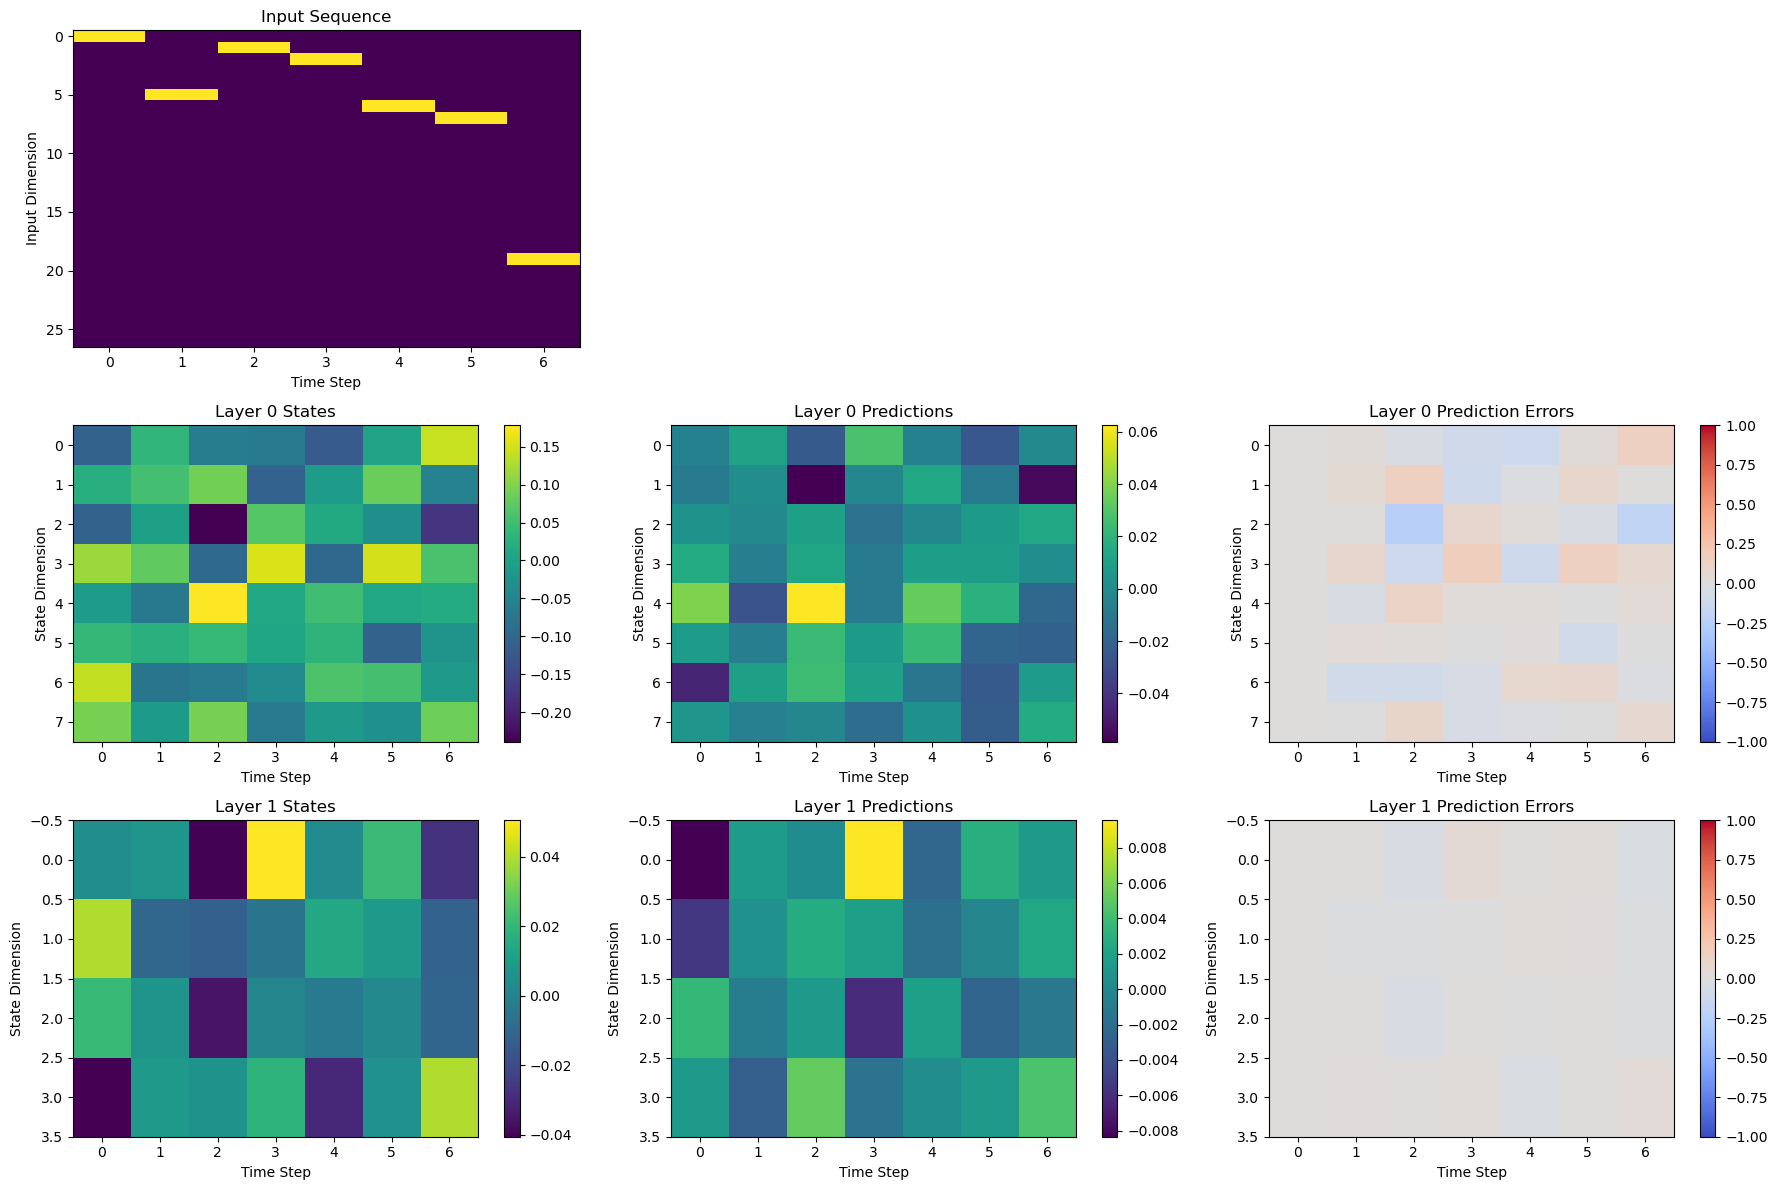

Layer 0 final prediction: [-0.00172234 -0.05516444  0.01351029  0.00095601 -0.01775887 -0.02075325
  0.00836018  0.01616217]
Layer 1 final prediction: [ 0.00127396  0.0023036  -0.00117448  0.00447387]

Running sequence with repetitions...

Processing time step 0

Processing time step 1

Processing time step 2

Processing time step 3

Processing time step 4

Processing time step 5

Processing time step 6

Processing time step 7

Processing time step 8

Processing time step 9


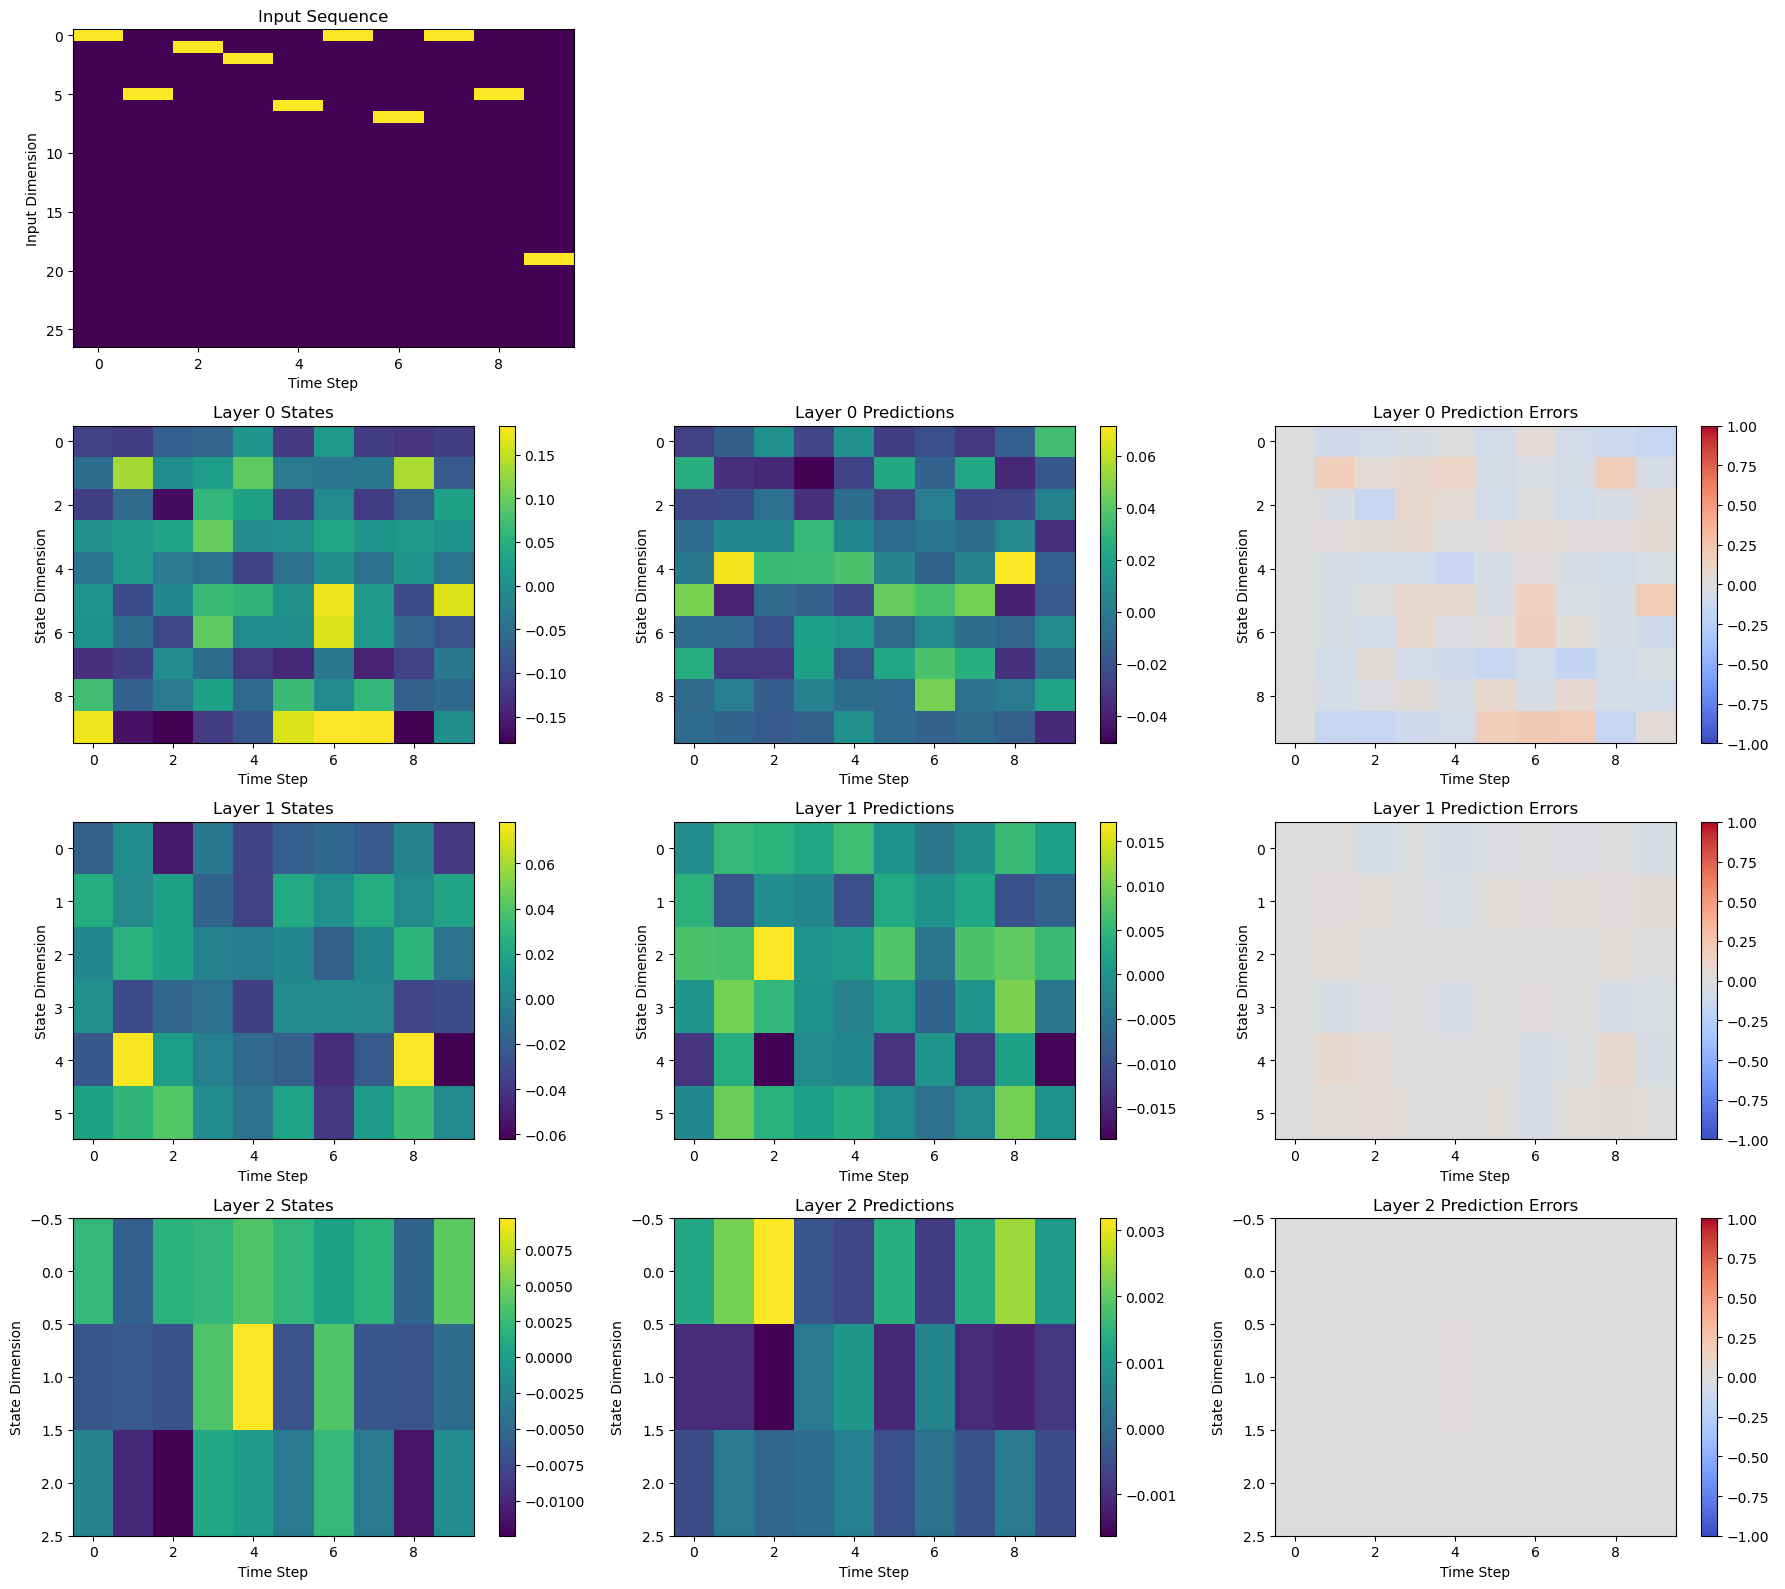

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class HTCPLayer:
    """
    Represents a single layer in the HTPC hierarchy.
    """
    def __init__(self, input_size, state_size, name="Layer"):
        self.name = name
        self.input_size = input_size
        self.state_size = state_size
        
        # Layer state
        self.state = np.zeros(state_size)
        self.prev_state = np.zeros(state_size)
        
        # Prediction-related matrices
        # Input-to-state mapping
        self.W_input = np.random.randn(state_size, input_size) * 0.1
        
        # Transition weights - how states transition to other states
        self.W_transition = np.random.randn(state_size, state_size) * 0.1
        
        # For top-down modulation from higher layers
        self.W_topdown = None  # Will be set if there's a higher layer
        
        # Learning rates
        self.lr_input = 0.1
        self.lr_transition = 0.05
        self.lr_topdown = 0.05
        
        # Prediction error
        self.prediction_error = np.zeros(state_size)
        
        # Prediction of the next state
        self.predicted_state = np.zeros(state_size)
        
    def update_state(self, bottom_up_input, top_down_input=None):
        """Update the layer's state based on bottom-up and top-down signals."""
        self.prev_state = self.state.copy()
        
        # Calculate state from bottom-up input
        input_driven_state = np.tanh(np.dot(self.W_input, bottom_up_input))
        
        # Apply top-down modulation if available
        if top_down_input is not None and self.W_topdown is not None:
            top_down_influence = np.dot(self.W_topdown, top_down_input)
            modulated_state = input_driven_state * (1 + np.tanh(top_down_influence))
            self.state = modulated_state
        else:
            self.state = input_driven_state
            
        # Generate prediction for the next state based on current state
        self.predicted_state = np.tanh(np.dot(self.W_transition, self.state))
        
        # Return the current state
        return self.state
    
    def calculate_prediction_error(self, actual_state):
        """Calculate prediction error based on actual vs predicted state."""
        self.prediction_error = actual_state - self.predicted_state
        return self.prediction_error
    
    def learn(self, bottom_up_input, prediction_error, top_down_input=None):
        """Update weights based on prediction errors."""
        # Update input weights
        delta_W_input = self.lr_input * np.outer(prediction_error, bottom_up_input)
        self.W_input += delta_W_input
        
        # Update transition weights
        delta_W_transition = self.lr_transition * np.outer(prediction_error, self.prev_state)
        self.W_transition += delta_W_transition
        
        # Update top-down weights if applicable
        if top_down_input is not None and self.W_topdown is not None:
            delta_W_topdown = self.lr_topdown * np.outer(prediction_error, top_down_input)
            self.W_topdown += delta_W_topdown


class HTCPNetwork:
    """
    A hierarchical network of HTCP layers.
    """
    def __init__(self, input_size, layer_sizes):
        """
        Initialize a HTCP network with specified layer sizes.
        
        Args:
            input_size: Size of the input vector
            layer_sizes: List of state sizes for each layer (from bottom to top)
        """
        self.layers = []
        
        # Create the layers
        prev_size = input_size
        for i, size in enumerate(layer_sizes):
            layer = HTCPLayer(prev_size, size, name=f"Layer_{i}")
            self.layers.append(layer)
            prev_size = size
        
        # Set up top-down connections
        for i in range(len(self.layers) - 1):
            next_layer_size = self.layers[i+1].state_size
            self.layers[i].W_topdown = np.random.randn(self.layers[i].state_size, next_layer_size) * 0.1
    
    def process_sequence(self, input_sequence, learning=True, plot=False):
        """
        Process a sequence of inputs through the network.
        
        Args:
            input_sequence: List of input vectors
            learning: Whether to update weights during processing
            plot: Whether to plot network activity
        
        Returns:
            Dictionary of layer states and prediction errors over time
        """
        sequence_length = len(input_sequence)
        num_layers = len(self.layers)
        
        # Initialize storage for tracking network activity
        history = {
            'inputs': [],
            'states': [[] for _ in range(num_layers)],
            'predictions': [[] for _ in range(num_layers)],
            'errors': [[] for _ in range(num_layers)]
        }
        
        # Process each input in the sequence
        for t, input_vector in enumerate(input_sequence):
            print(f"\nProcessing time step {t}")
            history['inputs'].append(input_vector.copy())
            
            # Forward pass: bottom-up
            layer_outputs = []
            current_input = input_vector
            
            # Pass through each layer from bottom to top
            for i, layer in enumerate(self.layers):
                # Get top-down input if not at the top layer
                top_down_input = None
                if i < num_layers - 1:
                    # No top-down on the first step
                    if t > 0:
                        top_down_input = self.layers[i+1].state
                
                # Update layer state
                layer_output = layer.update_state(current_input, top_down_input)
                layer_outputs.append(layer_output)
                current_input = layer_output
                
                # Store current state
                history['states'][i].append(layer.state.copy())
                history['predictions'][i].append(layer.predicted_state.copy())
            
            # On the next time step, calculate prediction errors and learn
            if t > 0:
                # Calculate prediction errors and learn (if enabled)
                for i, layer in enumerate(self.layers):
                    # For the lowest layer, compare against the actual input
                    if i == 0:
                        actual_state = layer.state
                    else:
                        actual_state = self.layers[i].state
                    
                    # Calculate prediction error based on previous prediction
                    error = layer.calculate_prediction_error(actual_state)
                    history['errors'][i].append(error.copy())
                    
                    # Update weights if learning is enabled
                    if learning:
                        if i == 0:
                            bottom_input = input_sequence[t-1]
                        else:
                            bottom_input = self.layers[i-1].state
                        
                        top_input = None
                        if i < num_layers - 1:
                            top_input = self.layers[i+1].prev_state
                        
                        layer.learn(bottom_input, error, top_input)
            
            # For the first time step, we have no prediction errors yet
            if t == 0:
                for i in range(num_layers):
                    history['errors'][i].append(np.zeros_like(self.layers[i].state))
        
        # Plot the network activity if requested
        if plot:
            self._plot_network_activity(history, sequence_length)
            
        return history
    
    def _plot_network_activity(self, history, sequence_length):
        """Plot the network activity over time."""
        num_layers = len(self.layers)
        fig, axes = plt.subplots(num_layers + 1, 3, figsize=(18, 4 * (num_layers + 1)))
        
        # Plot input
        ax = axes[0, 0]
        input_data = np.array(history['inputs'])
        ax.imshow(input_data.T, aspect='auto', cmap='viridis')
        ax.set_title('Input Sequence')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Input Dimension')
        
        # Empty plots for the input row
        axes[0, 1].axis('off')
        axes[0, 2].axis('off')
        
        # Plot each layer's activity
        for i in range(num_layers):
            # States
            ax = axes[i+1, 0]
            state_data = np.array(history['states'][i])
            im = ax.imshow(state_data.T, aspect='auto', cmap='viridis')
            ax.set_title(f'Layer {i} States')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('State Dimension')
            plt.colorbar(im, ax=ax)
            
            # Predictions
            ax = axes[i+1, 1]
            pred_data = np.array(history['predictions'][i])
            im = ax.imshow(pred_data.T, aspect='auto', cmap='viridis')
            ax.set_title(f'Layer {i} Predictions')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('State Dimension')
            plt.colorbar(im, ax=ax)
            
            # Errors
            ax = axes[i+1, 2]
            error_data = np.array(history['errors'][i])
            im = ax.imshow(error_data.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
            ax.set_title(f'Layer {i} Prediction Errors')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('State Dimension')
            plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        plt.show()


# Helper functions for creating and visualizing input sequences
def one_hot_encode(char, alphabet):
    """One-hot encode a character using the given alphabet."""
    index = alphabet.index(char)
    encoding = np.zeros(len(alphabet))
    encoding[index] = 1.0
    return encoding

def sequence_to_one_hot(sequence, alphabet):
    """Convert a character sequence to one-hot encoded vectors."""
    return [one_hot_encode(char, alphabet) for char in sequence]

def run_letter_sequence_example():
    """Run the HTPC network on a letter sequence example."""
    # Define alphabet and sequence
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "
    sequence = "A F B C G H T"
    
    # Convert to one-hot vectors
    input_vectors = sequence_to_one_hot(sequence.replace(" ", ""), alphabet)
    
    # Create HTPC network
    input_size = len(alphabet)
    layer_sizes = [8, 4]  # Two layers with sizes 8 and 4
    network = HTCPNetwork(input_size, layer_sizes)
    
    # Process the sequence
    history = network.process_sequence(input_vectors, learning=True, plot=True)
    
    # Print final predictions for each layer
    for i, layer in enumerate(network.layers):
        print(f"Layer {i} final prediction:", layer.predicted_state)
    
    return network, history

def run_repeated_sequence_example():
    """Run the HTPC network on a sequence with repetitions."""
    # Define alphabet and sequence
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "
    sequence = "A F B C G A H A F T"
    
    # Convert to one-hot vectors
    input_vectors = sequence_to_one_hot(sequence.replace(" ", ""), alphabet)
    
    # Create HTPC network with three layers
    input_size = len(alphabet)
    layer_sizes = [10, 6, 3]  # Three layers with decreasing sizes
    network = HTCPNetwork(input_size, layer_sizes)
    
    # Process the sequence
    history = network.process_sequence(input_vectors, learning=True, plot=True)
    
    return network, history


if __name__ == "__main__":
    # Run the simple letter sequence example
    print("Running simple letter sequence example...")
    network1, history1 = run_letter_sequence_example()
    
    # Run the repeated sequence example
    print("\nRunning sequence with repetitions...")
    network2, history2 = run_repeated_sequence_example()